In [1]:
import sys
sys.path.append('../input/imutils-054/imutils-0.5.4')

In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
import imutils
import datetime
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer

import pickle

In [4]:
label=[]
pathofimage=[]
data=[]

In [5]:
path_of_images="D:/DATA MINING/image/caltech101_classification"

In [10]:
class_of_images=["Airplanes","schooner","Motorbikes"]

In [11]:
def class_of_images_counter(label, name_class):
    counter=0
    for i in label:
        if i==name_class:
            counter=counter+1
    return counter

In [12]:
for x in class_of_images:
    list_of_images=[]
    new_Path=path_of_images+"/"+x+"/"
    print(new_Path)
    
    for img in os.listdir(new_Path):
        if(img.endswith(".jpg")):
            list_of_images.append(img)
            
    list_of_images=sorted(list_of_images)
    
    for imgs in list_of_images:
        labels=x
        img_path=os.path.sep.join([path_of_images,x,imgs])
        img=cv2.imread(img_path)
        (height,width)=img.shape[:2]
        
        img=load_img(img_path, target_size=(224,224))
        img=img_to_array(img)
        data.append(img)
        label.append(labels)
        pathofimage.append(img_path)

D:/DATA MINING/image/caltech101_classification/Airplanes/
D:/DATA MINING/image/caltech101_classification/schooner/
D:/DATA MINING/image/caltech101_classification/Motorbikes/


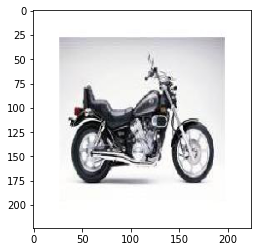

In [13]:
image_plot=plt.imshow(img.astype('uint8'))
plt.show()

In [14]:
aeroplane_counter=class_of_images_counter(label, "airplanes")
schooner_counter=class_of_images_counter(label, "schooner")
motorbike_counter=class_of_images_counter(label, "Motorbikes")

aeroplane_counter, schooner_counter, motorbike_counter

(800, 126, 1596)

In [11]:
maximum_no=max(aeroplane_counter, schooner_counter, motorbike_counter)

In [12]:
def scale_making(imgs):
    value_scale=random.uniform(0.8,1.2)
    imagescaled=cv2.resize(imgs.copy(), None,fx=value_scale, fy=value_scale)
    return imagescaled

In [13]:
def rotate_making(imgs):
    (height,weight)=imgs.shape[:2]
    val_rotate=random.uniform(-5,5)
    centerofsizes=(weight/2,height/2)
    
    B=cv2.getRotationMatrix2D(centerofsizes,val_rotate,scale=1)
    rotatedimage=cv2.warpAffine(imgs.copy(),B,(weight,height))
    return rotatedimage

In [14]:
def data_augmentation(counter,maximum_no,class_name):
    while counter<maximum_no:
        for imgs in data:
            if counter<maximum_no:
                imageaugmentation=imgs.copy()
                imageaugmentation=scale_making(imageaugmentation)
                cv2.imwrite("imageaugmentation.jpg", imageaugmentation)
                imageaugmentation=load_img("imageaugmentation.jpg", target_size=(224,224))
                imageaugmentation=img_to_array(imageaugmentation)
                os.remove("imageaugmentation.jpg")
                data.append(imageaugmentation)
                label.append(class_name)
                pathofimage.append(img_path)
                counter=class_of_images_counter(label,class_name)
            else:
                break
            
            if counter<maximum_no:
                imageaugmentation=imgs.copy()
                imageaugmentation=rotate_making(imageaugmentation)
                cv2.imwrite("imageaugmentation.jpg",imageaugmentation)
                imageaugmentation=load_img("imageaugmentation.jpg", target_size=(224,224))
                imageaugmentation=img_to_array(imageaugmentation)
                os.remove("imageaugmentation.jpg")
                data.append(imageaugmentation)
                label.append(class_name)
                pathofimage.append(img_path)
                counter=class_of_images_counter(label,class_name)
            else:
                break
                

In [15]:
data_augmentation(motorbike_counter, maximum_no, "Motorbikes")
data_augmentation(schooner_counter, maximum_no, "schooner")

In [16]:
aeroplane_counter=class_of_images_counter(label, "airplanes")
schooner_counter=class_of_images_counter(label, "schooner")
motorbike_counter=class_of_images_counter(label, "Motorbikes")

aeroplane_counter, schooner_counter, motorbike_counter

(800, 800, 800)

In [17]:
data=np.array(data, dtype="float32")/255.0

In [18]:
label=np.array(label)
pathofimage=np.array(pathofimage)

In [19]:
y=LabelBinarizer()
label=y.fit_transform(label)

In [20]:
if len(y.classes_)==2:
    print("2classes")
    label=to_categorical(label)

In [64]:
split=train_test_split(data,label,pathofimage,test_size=0.05,random_state=42)

In [66]:
(images_train, images_test)= split[:2]
(labels_train, labels_test)= split[2:4]
(paths_train, paths_test)= split[4:]

In [68]:
A=open("multiclass_testing.txt","w")
A.write("\n".join(paths_test))
A.close()

In [24]:
VGG=VGG16(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

In [25]:
VGG.trainable=False

In [26]:
flattenlayer=VGG.output
flattenlayer=Flatten()(flattenlayer)

In [27]:
softmax=Dense(512, activation="relu")(flattenlayer)
softmax=Dropout(0.5)(softmax)
softmax=Dense(512, activation="relu")(softmax)
softmax=Dropout(0.5)(softmax)
softmax=Dense(len(y.classes_), activation="softmax",name="class_labels")(softmax)

In [28]:
model=Model(inputs=VGG.input, outputs=(softmax))

In [29]:
INIT_LR= 1e-4
NUM_EPOCHS=10
BATCH_SIZE=32

In [30]:
lossing={"class_labels": "categorical_crossentropy",}

In [31]:
training={"class_labels":labels_train,}

In [32]:
testing={"class_labels":labels_test,}

In [33]:
pathofmodel="model.h5"
checkpoint=ModelCheckpoint(filepath=pathofmodel, accurate='val_accuracy', mode='max',Best=True)

In [34]:
option= Adam(INIT_LR)
model.compile(loss=lossing, optimizer=option, metrics=["accuracy"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
G=model.fit(images_train, training, validation_data=(images_test,testing), batch_size=BATCH_SIZE,epochs=NUM_EPOCHS, callbacks=[checkpoint],verbose=1)

Epoch 1/10
72/72 [==============================] - 433s 6s/step - loss: 0.5939 - accuracy: 0.7132 - val_loss: 0.3373 - val_accuracy: 0.8417
Epoch 2/10
72/72 [==============================] - 484s 7s/step - loss: 0.3484 - accuracy: 0.8386 - val_loss: 0.2538 - val_accuracy: 0.8667
Epoch 3/10
72/72 [==============================] - 455s 6s/step - loss: 0.2561 - accuracy: 0.8930 - val_loss: 0.2103 - val_accuracy: 0.9083
Epoch 4/10
72/72 [==============================] - 512s 7s/step - loss: 0.2006 - accuracy: 0.9184 - val_loss: 0.1835 - val_accuracy: 0.9167
Epoch 5/10
72/72 [==============================] - 531s 7s/step - loss: 0.1459 - accuracy: 0.9434 - val_loss: 0.1779 - val_accuracy: 0.9250
Epoch 6/10
72/72 [==============================] - 450s 6s/step - loss: 0.1412 - accuracy: 0.9434 - val_loss: 0.1307 - val_accuracy: 0.9417
Epoch 7/10
72/72 [==============================] - 447s 6s/step - loss: 0.0973 - accuracy: 0.9636 - val_loss: 0.1468 - val_accuracy: 0.9083
Epoch 8/10
72

In [36]:
A=open("y.pickle","wb")
A.write(pickle.dumps(y))
A.close()

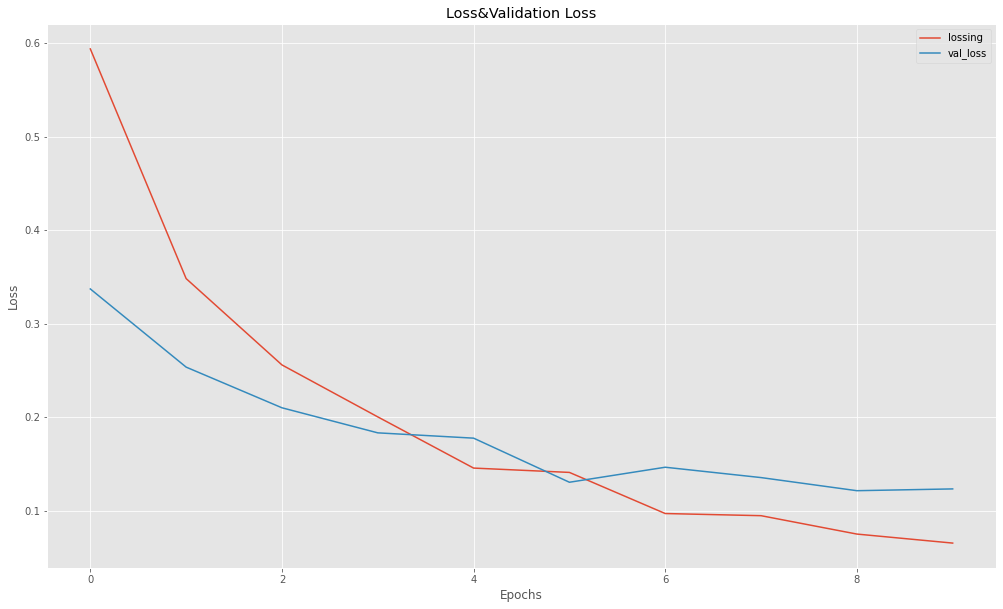

In [48]:
Nameloss=["loss"]
B=np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(17,10))
plt.title("Loss&Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(B, G.history["loss"], label="lossing")
plt.plot(B, G.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

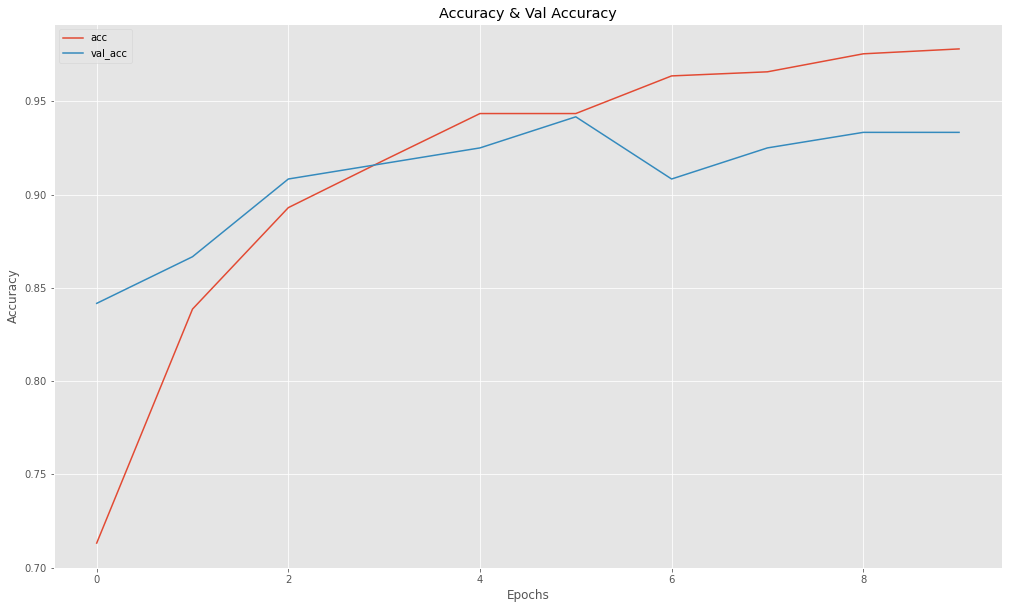

In [56]:
plt.style.use("ggplot")
plt.figure(figsize=(17,10))

plt.plot(B, G.history["accuracy"], label="acc")
plt.plot(B, G.history["val_accuracy"], label="val_acc")

plt.title("Accuracy & Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [69]:
path="multiclass_testing.txt"
nameoffile=open(path).read().strip().split("\n")
pathofimage = []

for A in nameoffile:
    pathofimage.append(A)

In [70]:
model=load_model("./model.h5")

In [71]:
y=pickle.loads(open("./y.pickle","rb").read())

class= Motorbikes


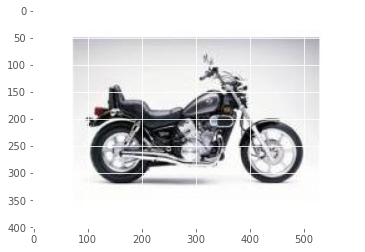

class= Motorbikes


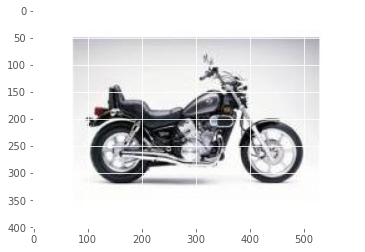

class= schooner


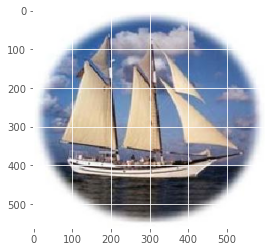

class= Motorbikes


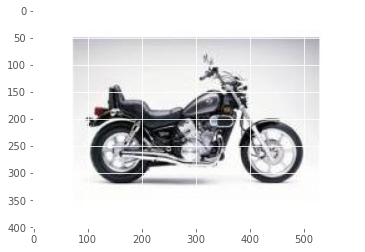

class= Motorbikes


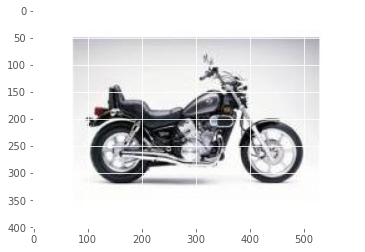

class= schooner


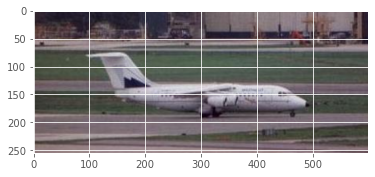

In [86]:
cntr = 0

for pathofimages in pathofimage:
    img=load_img(pathofimages, target_size=(224,224))
    img=img_to_array(img)/255.0
    img=np.expand_dims(img,axis=0)
    
    (labelpreds)=model.predict(img)
    
    k=np.argmax(labelpreds, axis=1)
    labels=y.classes_[k][0]
    
    img=cv2.imread(pathofimages)
    img=imutils.resize(img, width=600)
    (height, weight)= img.shape[:2]
    
    print("class=", labels)
    imgplot=plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()
    cntr+=1
    if(cntr>5):
        break

# References

https://www.kaggle.com/code/maricinnamon/multiclass-classification-caltech101-tensorflow

# Dataset

https://www.kaggle.com/datasets/maricinnamon/caltech101-airplanes-motorbikes-schooners?resource=download